In [1]:
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
import uncertainties
from uncertainties import unumpy

sys.path.append("..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

%load_ext autoreload
%autoreload 1
%aimport longitudinalProfile.violin
from longitudinalProfile.violin import makeViolinBeamEnergy, makeViolinBeamEnergyDataSim

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v43'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [3]:
def getHist(datatype, beamEnergies, level="clue3d"):
    if level == "clue3d":
        return {beamEnergy : histStore
            .get(HistogramId("Clus3DClusteredEnergyPerLayer", clueParams, datatype))
            .getHistogram(HistogramKind.PROFILE)
            [{
                "mainOrAllTracksters" : hist.loc("mainTrackster"),
                # Project on clus3D_size
                "beamEnergy" : hist.loc(beamEnergy)
            }]
            .project("clus2D_layer")
            for beamEnergy in beamEnergies
        }
    elif level == "rechits":
        return {beamEnergy : histStore
            .get(HistogramId("RechitsEnergyReconstructedPerLayer", clueParams, datatype))
            .getHistogram(HistogramKind.PROFILE)
            [{
                "beamEnergy" : hist.loc(beamEnergy)
            }]
            for beamEnergy in beamEnergies
        }
    else:
        raise ValueError()

In [4]:
def makeViolinBeamEnergy_wrapper(datatype:str, beamEnergies=beamEnergies):
    hists = getHist(datatype, beamEnergies)
    makeViolinBeamEnergy(hists, datatype)
    plt.xlim(0, 29)
    

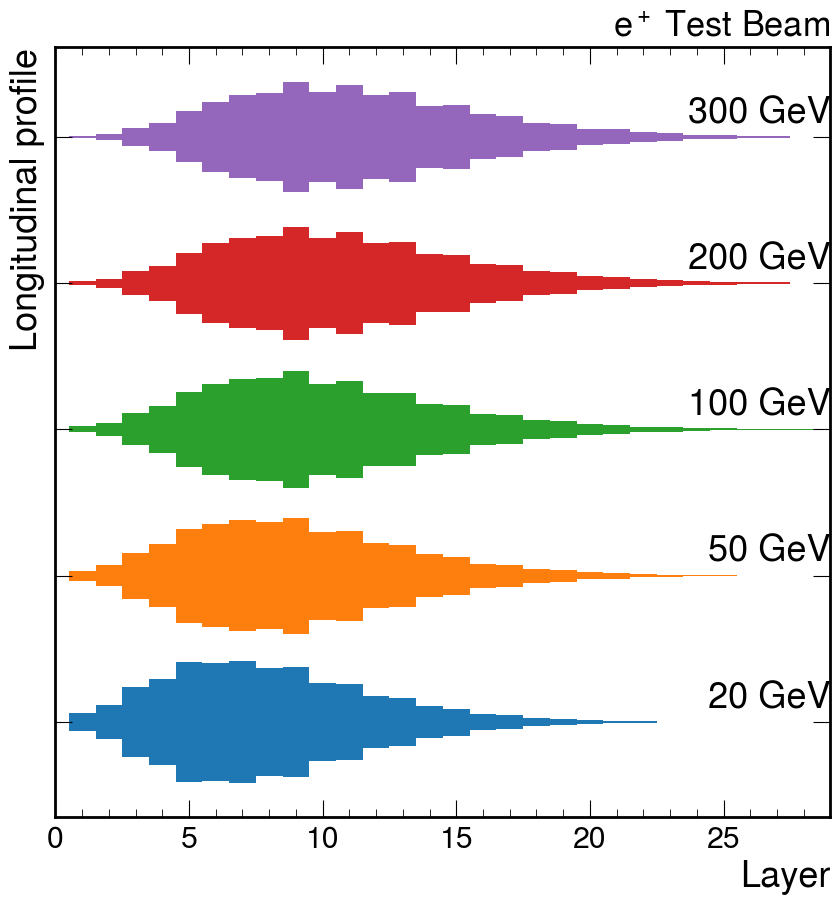

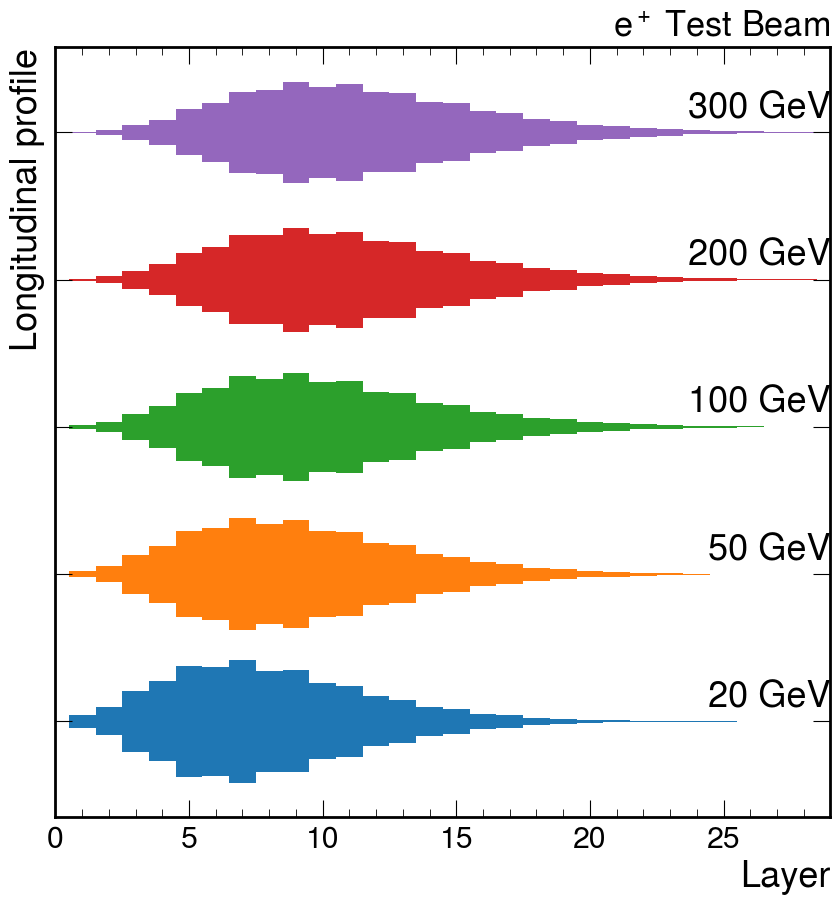

In [5]:
beamEnergiesToPlot = [20, 50, 100, 200, 300]
makeViolinBeamEnergy_wrapper("data", beamEnergies=beamEnergiesToPlot)
#plt.savefig("plots/violin-data.pdf", bbox_inches="tight")
makeViolinBeamEnergy_wrapper("sim_proton_v46_patchMIP", beamEnergies=beamEnergiesToPlot)
#plt.savefig("plots/violin-sim.pdf", bbox_inches="tight")

(-0.08259563941020198, 0.63)

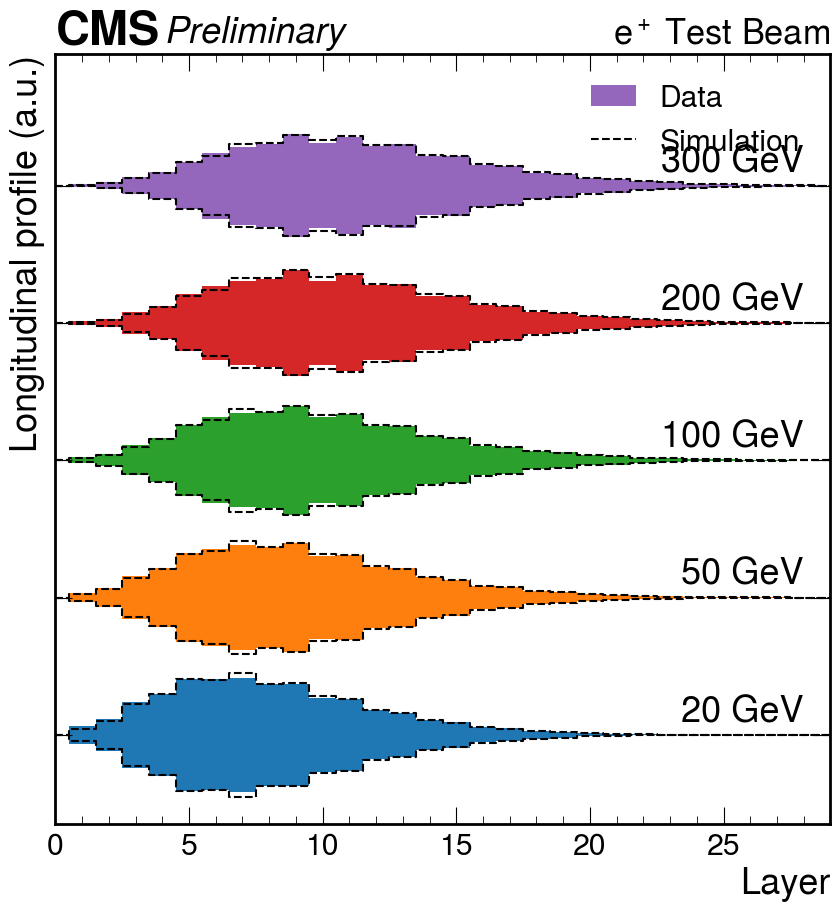

In [6]:
makeViolinBeamEnergyDataSim(getHist("data", beamEnergiesToPlot), getHist("sim_proton_v46_patchMIP", beamEnergiesToPlot))
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
plt.gca().legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right")
plt.xlim(0, 29)
plt.ylim(top=0.63)

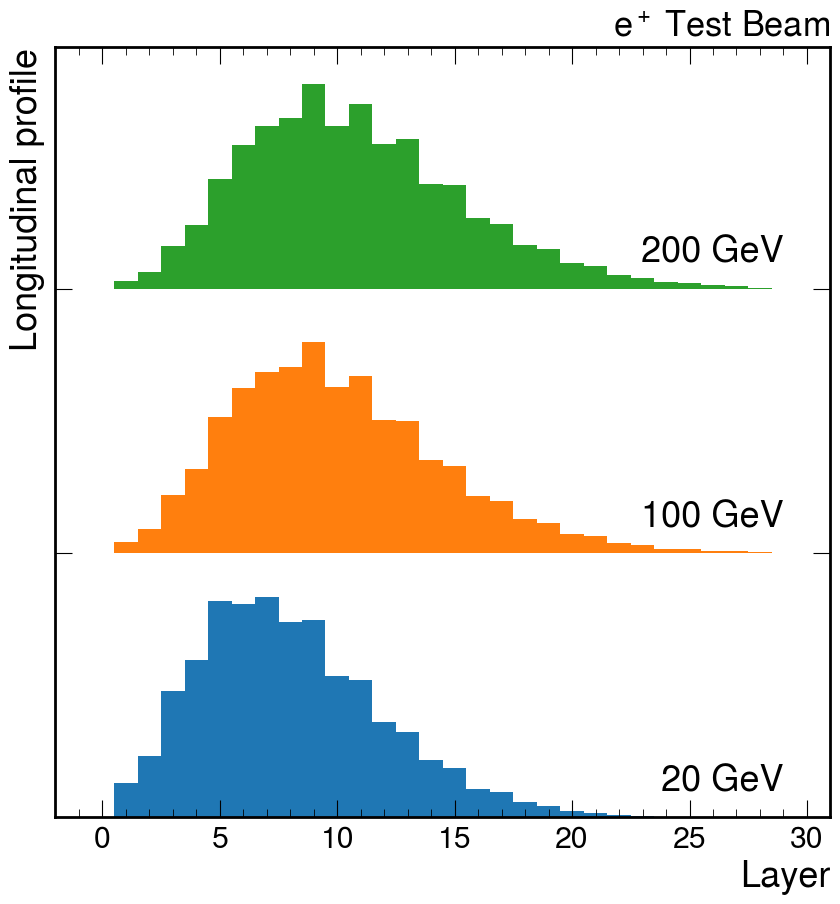

In [7]:
hists = getHist("data", [20, 100, 200])
makeViolinBeamEnergy(hists, "data", symmetrize=False)

In [8]:
h = hists[100]
xVals = np.linspace(1, 28, 500)
kde = gaussian_kde(h.axes[0].edges[1:], weights=h.view().value, bw_method=0.25)(xVals)
kde

array([0.00248268, 0.00265543, 0.00283669, 0.00302666, 0.00322553,
       0.00343349, 0.00365073, 0.00387744, 0.00411378, 0.00435994,
       0.00461609, 0.00488239, 0.00515902, 0.00544613, 0.00574388,
       0.00605241, 0.00637189, 0.00670245, 0.00704423, 0.00739737,
       0.00776198, 0.00813819, 0.00852611, 0.00892585, 0.0093375 ,
       0.00976114, 0.01019686, 0.01064473, 0.0111048 , 0.01157711,
       0.0120617 , 0.01255859, 0.0130678 , 0.01358932, 0.01412314,
       0.01466923, 0.01522756, 0.01579808, 0.01638074, 0.01697546,
       0.01758216, 0.01820076, 0.01883116, 0.01947327, 0.02012696,
       0.02079214, 0.02146867, 0.02215643, 0.02285529, 0.02356512,
       0.02428578, 0.02501713, 0.02575903, 0.02651133, 0.02727388,
       0.02804652, 0.02882909, 0.02962141, 0.03042332, 0.03123463,
       0.03205513, 0.03288462, 0.03372287, 0.03456965, 0.03542469,
       0.03628772, 0.03715843, 0.0380365 , 0.03892159, 0.03981331,
       0.04071128, 0.04161506, 0.04252419, 0.04343818, 0.04435

In [9]:
np.trapz(kde, x=xVals)

0.997638098362956

In [10]:
def plotKDE(h:hist.Hist, ax, norm=None, **kwargs):
    if norm is None:
        norm = np.sum(h.view().value)
    xVals = np.linspace(1, 28, 500)
    kde = gaussian_kde(h.axes[0].edges[1:], weights=h.view().value, bw_method=0.25)(xVals)
    ax.plot(xVals, kde*norm, **kwargs)
    return xVals, kde, kde*norm

def makeViolinAndProfile(datatype, beamEnergies):
    fig = plt.figure(figsize=(10, 14))
    gs = fig.add_gridspec(2, 1, hspace=0, height_ratios=(2.5, 1))
    violin_ax, profile_ax = gs.subplots(sharex=True)

    hists = getHist(datatype, beamEnergies=beamEnergies)
    makeViolinBeamEnergy(hists, datatype, ax=violin_ax)
    violin_ax.set_xlim(0.5, 28.5)

    for energy, h in hists.items():
        #norm = 1./np.sum(h.view().value)
        norm = 1.
        #profile_ax.plot(h.axes[0].edges[1:], norm*h.view().value, label=f"{energy} GeV")
        kde = gaussian_kde(h.axes[0].edges[1:], weights=norm*h.view().value, bw_method=0.25)
        xVals = np.linspace(1, 28, 500)
        profile_ax.plot(xVals, kde(xVals), label=f"{energy} GeV")
    profile_ax.set_xlabel("Layer")
    profile_ax.set_ylabel("Mean energy on layer\n(smoothed, normalized)")
    profile_ax.legend()

def makeProfile(profile_ax:matplotlib.figure.Axes, hists:dict[int, hist.Hist], hists_sim:dict[int, hist.Hist]):
    for (energy, h), h_sim in zip(hists.items(), hists_sim.values()):
        #norm = 1./np.sum(h.view().value)
        norm = 1.
        #profile_ax.plot(h.axes[0].edges[1:], norm*h.view().value, label=f"{energy} GeV")
        
        plotKDE(h, ax=profile_ax, norm=norm, label=f"{energy} GeV")
        plotKDE(h_sim, ax=profile_ax, norm=norm, linestyle="--", color="black", alpha=0.8)
        
    profile_ax.set_xlabel("Layer")
    profile_ax.set_ylabel("Mean energy on layer\n(smoothed, normalized)")
    profile_ax.legend()

def makeViolinAndProfile_dataSimOverlaid(beamEnergies, size="large", symmetrize=True):
    fig = plt.figure(figsize=(10, 14) if size=="large" else (9, 11))
    gs = fig.add_gridspec(2, 1, hspace=0, height_ratios=(2.5 if size == "large" else 2., 1))
    violin_ax, profile_ax = gs.subplots(sharex=True)

    hists = getHist("data", beamEnergies=beamEnergies)
    hists_sim = getHist("sim_proton_v46_patchMIP", beamEnergies=beamEnergies)
    makeViolinBeamEnergyDataSim(hists, hists_sim, ax=violin_ax, symmetrize=symmetrize)
    violin_ax.set_xlim(0.5, 28.5)
    violin_ax.set_ylim(top=0.63 if size=="large" else 0.35)
    handles, labels = violin_ax.get_legend_handles_labels()
    order = [1, 0]
    violin_ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right")

    makeProfile(profile_ax, hists, hists_sim)
    profile_ax.set_ylabel(r"Mean energy on layer" "\n" r"\fontsize{18pt}{3em}\selectfont{}(smoothed, normalized)", usetex=True)
    return violin_ax, profile_ax

<Axes: xlabel='Layer', ylabel='Mean energy on layer\n(smoothed, normalized)'>

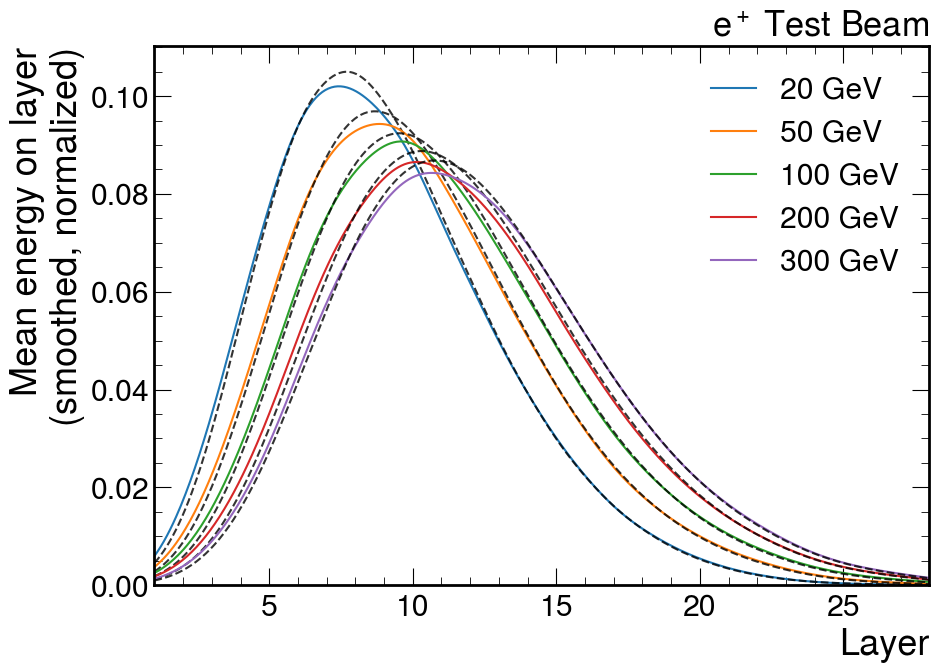

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
makeProfile(ax, getHist("data", beamEnergies=beamEnergiesToPlot), getHist("sim_proton_v46_patchMIP", beamEnergies=beamEnergiesToPlot))
ax.set_ylabel("Mean energy on layer\n(smoothed, normalized)")
ax.set_xlim(1, 28)
ax.set_ylim(bottom=0)
hep.cms.lumitext("$e^+$ Test Beam")

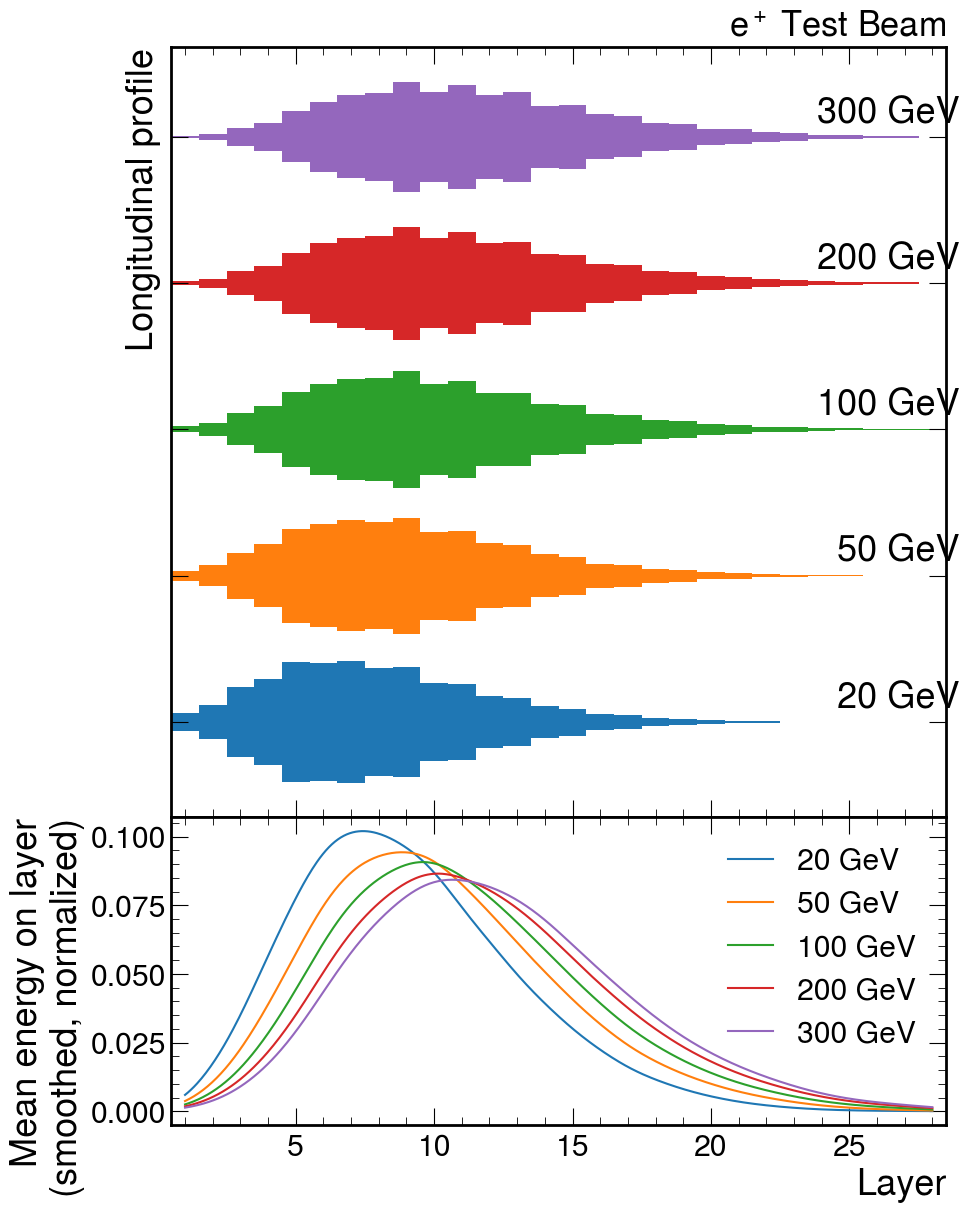

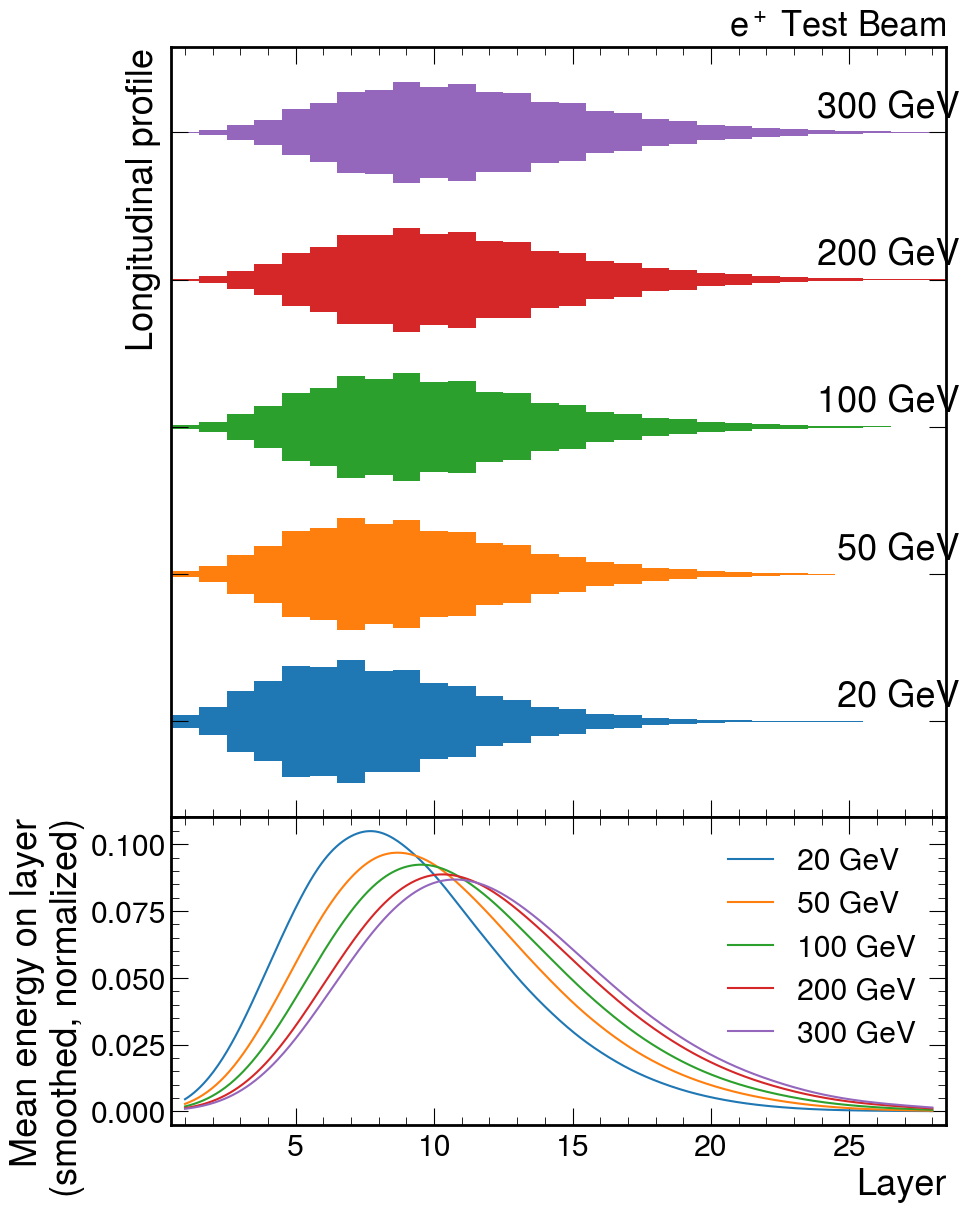

In [12]:
makeViolinAndProfile("data", beamEnergiesToPlot)
#plt.savefig("plots/violin-profile-data.pdf", bbox_inches="tight")
makeViolinAndProfile("sim_proton_v46_patchMIP", beamEnergiesToPlot)
#plt.savefig("plots/violin-profile-sim.pdf", bbox_inches="tight")
None

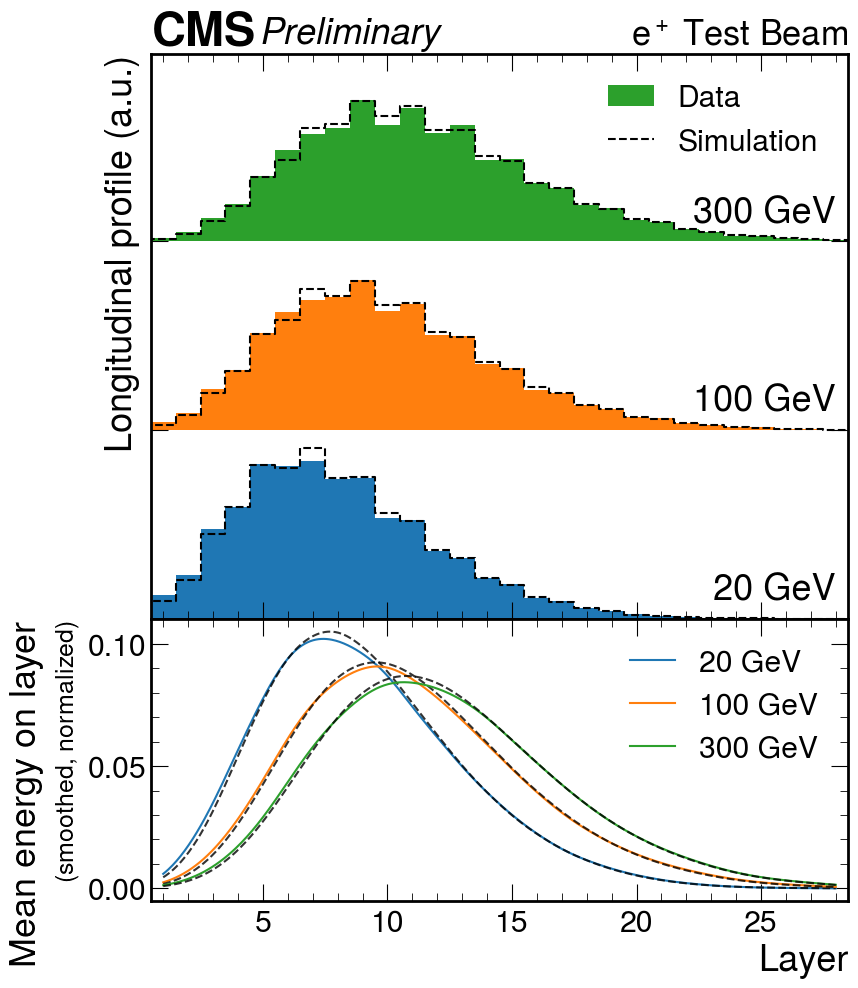

In [13]:
# makeViolinAndProfile_dataSimOverlaid(beamEnergiesToPlot)
# plt.savefig("plots/violin-profile-datasim.pdf", bbox_inches="tight")
# makeViolinAndProfile_dataSimOverlaid([20, 100, 300], size="small")
# plt.savefig("plots/violin-profile-datasim-small.pdf", bbox_inches="tight")
violin_ax, profile_ax = makeViolinAndProfile_dataSimOverlaid([20, 100, 300], size="small", symmetrize=False)
violin_ax.set_ylim(top=0.38)
plt.savefig("plots/violin-profile-datasim-small-nonsym.pdf", bbox_inches="tight")

### Rechits / CLUE3D raw

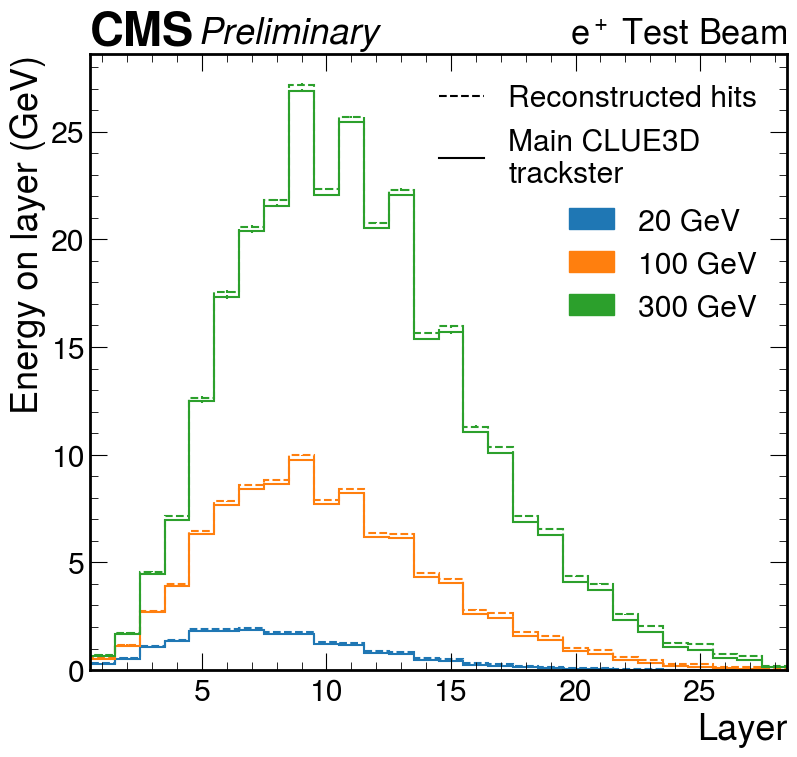

In [14]:
beamEnergiesToPlot_comp = [20., 100., 300.]
colors = ["tab:blue", "tab:orange", "tab:green"]
datatype = "data"
fig, ax = plt.subplots(figsize=(9, 8))
h_rechits = getHist(datatype, beamEnergiesToPlot_comp, "rechits")
h_clue3d = getHist(datatype, beamEnergiesToPlot_comp, "clue3d")

#hep.histplot([h_rechits, h_clue3d], label=['Reconstructed hits', 'Main CLUE3D\ntrackster'], color=colors)
hep.histplot(list(h_rechits.values()), linestyle="--", color=colors)
hep.histplot(list(h_clue3d.values()), color=colors)

legend_handes = [mlines.Line2D([], [], color='black', linestyle="--", label='Reconstructed hits'),
                 mlines.Line2D([], [], color='black', label='Main CLUE3D\ntrackster')]
for beamEnergy, color in zip(h_rechits.keys(), colors):
    legend_handes.append(mpatches.Patch(color=color, label=f"{int(beamEnergy)} GeV"))

ax.set_xlim(1, 29)
ax.set_xlabel("Layer")
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.array([5, 10, 15, 20, 25])+0.5))
class IntegerAxisFormatter(matplotlib.ticker.ScalarFormatter):
    def __call__(self, x: float, pos: int = ...) -> str:
        return super().__call__(x+0.5, pos)
#ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter([5, 10, 15, 20, 25]))
ax.set_ylim(bottom=0)
ax.set_ylabel("Energy on layer (GeV)")
legend_1 = ax.legend(handles=legend_handes[:2])
ax.legend(handles=legend_handes[2:], bbox_to_anchor=(1, 0.8))
ax.add_artist(legend_1)
hep.cms.text("Preliminary", ax=ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=ax)
plt.savefig("plots/rechits-clue-comparison-nonsmoothed.pdf", bbox_inches="tight")

Ratio plot version

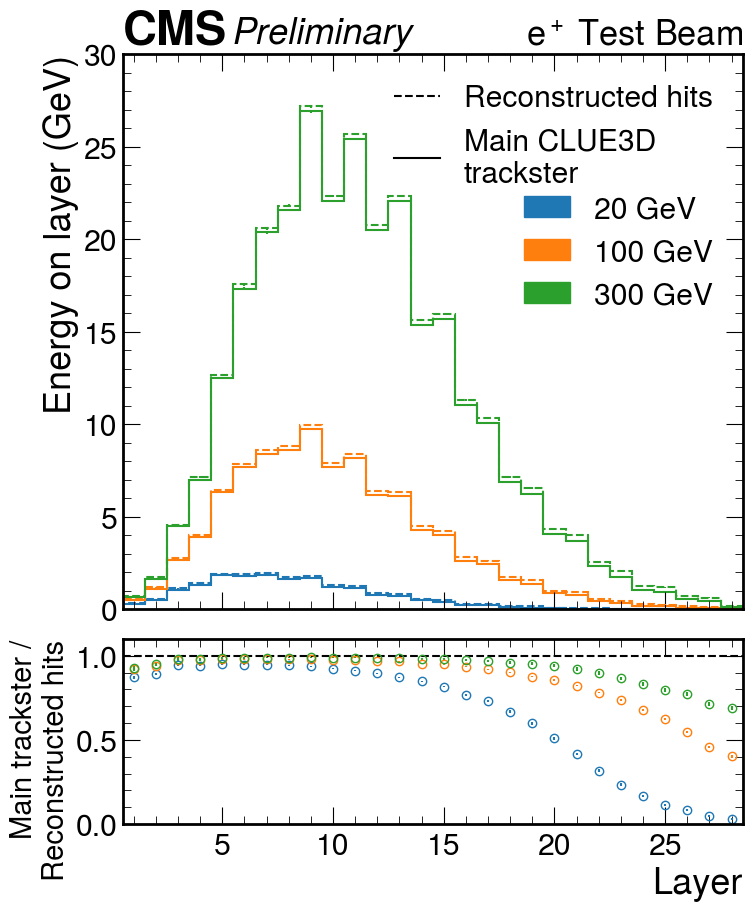

In [15]:
beamEnergiesToPlot_comp = [20., 100., 300.]
colors = ["tab:blue", "tab:orange", "tab:green"]
datatype = "data"
fig = plt.figure(figsize=(8, 10))
grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)

h_rechits = getHist(datatype, beamEnergiesToPlot_comp, "rechits")
h_clue3d = getHist(datatype, beamEnergiesToPlot_comp, "clue3d")

#hep.histplot([h_rechits, h_clue3d], label=['Reconstructed hits', 'Main CLUE3D\ntrackster'], color=colors)
hep.histplot(list(h_rechits.values()), linestyle="--", color=colors, ax=main_ax)
hep.histplot(list(h_clue3d.values()), color=colors, ax=main_ax)

legend_handes = [mlines.Line2D([], [], color='black', linestyle="--", label='Reconstructed hits'),
                 mlines.Line2D([], [], color='black', label='Main CLUE3D\ntrackster')]
for beamEnergy, color in zip(h_rechits.keys(), colors):
    legend_handes.append(mpatches.Patch(color=color, label=f"{int(beamEnergy)} GeV"))

main_ax.set_xlim(1, 29)
main_ax.set_xlabel("")
subplot_ax.set_xlabel("Layer")
main_ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.array([5, 10, 15, 20, 25])+0.5))
class IntegerAxisFormatter(matplotlib.ticker.ScalarFormatter):
    def __call__(self, x: float, pos: int = ...) -> str:
        return super().__call__(x+0.5, pos)
#ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
main_ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter([5, 10, 15, 20, 25]))
main_ax.set_ylim(bottom=0)
main_ax.set_ylabel("Energy on layer (GeV)")
legend_1 = main_ax.legend(handles=legend_handes[:2])
main_ax.legend(handles=legend_handes[2:], bbox_to_anchor=(1, 0.8))
main_ax.add_artist(legend_1)
hep.cms.text("Preliminary", ax=main_ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=main_ax)
subplot_ax.axhline(1, color="black", linestyle="--")

for beamEnergy, color in zip(h_rechits.keys(), colors):
    ## Ratio panel
    # Uncertainty is computed by  error propagation (only valid in case sigma << mu which is the case here)
    # unumpy does not like division by zero so do it by hand
    ratio = [uncertainties.ufloat(data_val, data_std) / uncertainties.ufloat(sim_val, sim_std) if sim_val > 0 else uncertainties.ufloat(np.nan, np.nan) 
        for data_val, data_std, sim_val, sim_std in zip(h_clue3d[beamEnergy].values(), np.sqrt(h_clue3d[beamEnergy].variances()), h_rechits[beamEnergy].values(), np.sqrt(h_rechits[beamEnergy].variances()))]
    # ratio = unumpy.uarray(h_data.values(), np.sqrt(h_data.variances())) / unumpy.uarray(h_sim.values(), np.sqrt(h_sim.variances())) 
    subplot_ax.errorbar(x=h_clue3d[beamEnergy].axes[0].centers, y=[val.nominal_value for val in ratio], yerr=[val.std_dev for val in ratio],
                                fmt="o", color=color, markerfacecolor="none")

subplot_ax.set_ylabel("Main trackster /\nReconstructed hits", fontsize=21)
subplot_ax.set_ylim(0, 1.1)
main_ax.set_ylim(top=30)
plt.savefig("plots/rechits-clue-comparison-nonsmoothed-ratio.pdf", bbox_inches="tight")

In [16]:
np.sqrt(h_clue3d[20].variances())/h_clue3d[20].values()

array([       nan, 0.00581893, 0.00447444, 0.00328335, 0.00280529,
       0.00232764, 0.0020419 , 0.00189966, 0.00187108, 0.00197047,
       0.00230898, 0.00256858, 0.00301937, 0.00351972, 0.00408757,
       0.00473658, 0.00585351, 0.00655402, 0.00815926, 0.00956608,
       0.01246392, 0.01547376, 0.02134516, 0.0286461 , 0.04154358,
       0.05861011, 0.07984482, 0.09702095, 0.13606918,        nan])

### CLUE3D data/sim raw

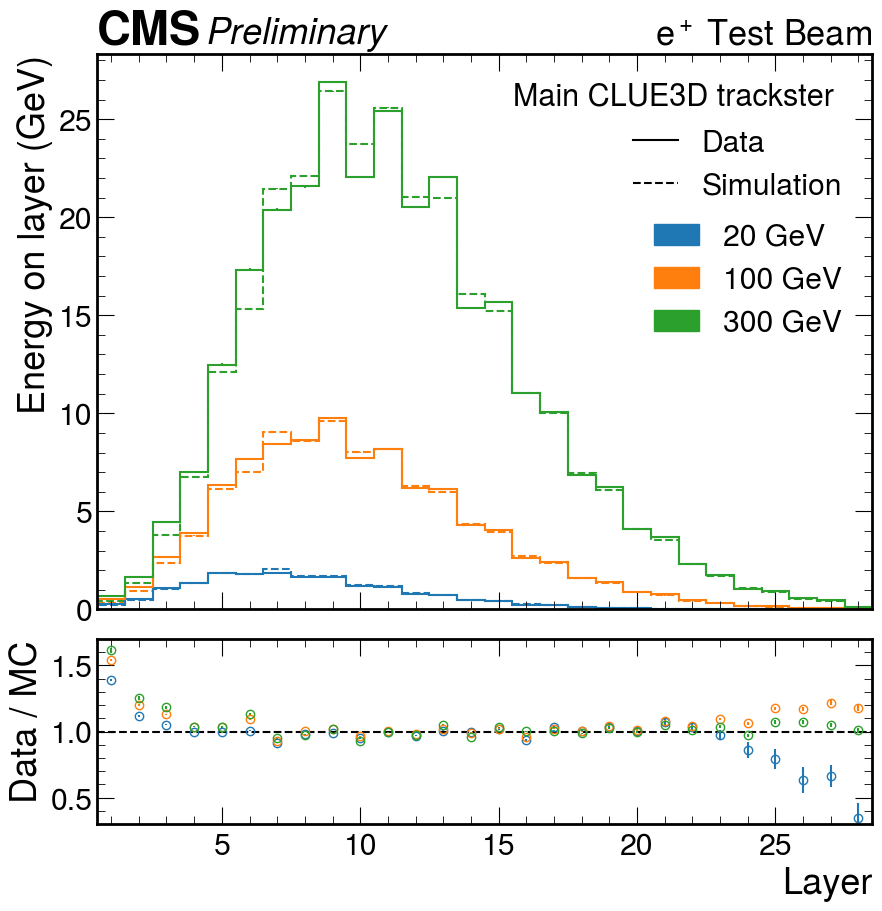

In [17]:
beamEnergiesToPlot_comp = [20., 100., 300.]
colors = ["tab:blue", "tab:orange",# "tab:red", 
          "tab:green"]
datatype = "data"
fig = plt.figure(figsize=(10, 10))
grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)

#h_rechits = getHist(datatype, beamEnergiesToPlot_comp, "rechits")
h_clue3d_data = getHist("data", beamEnergiesToPlot_comp, "clue3d")
h_clue3d_sim = getHist("sim_proton_v46_patchMIP", beamEnergiesToPlot_comp, "clue3d")

#hep.histplot([h_rechits, h_clue3d], label=['Reconstructed hits', 'Main CLUE3D\ntrackster'], color=colors)
hep.histplot(list(h_clue3d_sim.values()), linestyle="--", color=colors, ax=main_ax)
hep.histplot(list(h_clue3d_data.values()), color=colors, ax=main_ax)

subplot_ax.axhline(1, color="black", linestyle="--")

legend_handes = [mlines.Line2D([], [], color='black', label='Data'),
                 mlines.Line2D([], [], color='black', linestyle="--", label='Simulation'),]
for beamEnergy, color in zip(h_clue3d_data.keys(), colors):
    legend_handes.append(mpatches.Patch(color=color, label=f"{int(beamEnergy)} GeV"))
    h_data = h_clue3d_data[beamEnergy] # avoid empty bins causing div by 0
    h_sim = h_clue3d_sim[beamEnergy]
    ## Ratio panel
    # Uncertainty is computed by  error propagation (only valid in case sigma << mu which is the case here)
    # unumpy does not like division by zero so do it by hand
    ratio = [uncertainties.ufloat(data_val, data_std) / uncertainties.ufloat(sim_val, sim_std) if sim_val > 0 else uncertainties.ufloat(np.nan, np.nan) for data_val, data_std, sim_val, sim_std in zip(h_data.values(), np.sqrt(h_data.variances()), h_sim.values(), np.sqrt(h_sim.variances()))]
    # ratio = unumpy.uarray(h_data.values(), np.sqrt(h_data.variances())) / unumpy.uarray(h_sim.values(), np.sqrt(h_sim.variances())) 
    subplot_ax.errorbar(x=h_data.axes[0].centers, y=[val.nominal_value for val in ratio], yerr=[val.std_dev for val in ratio],
                                fmt="o", color=color, markerfacecolor="none")

main_ax.set_xlim(1, 28+1)
main_ax.set_xlabel("")
subplot_ax.set_xlabel("Layer")
main_ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.array([5, 10, 15, 20, 25])+0.5))
class IntegerAxisFormatter(matplotlib.ticker.ScalarFormatter):
    def __call__(self, x: float, pos: int = ...) -> str:
        return super().__call__(x+0.5, pos)
#ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
main_ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter([5, 10, 15, 20, 25]))
main_ax.set_ylim(bottom=0)
main_ax.set_ylabel("Energy on layer (GeV)")

main_ax.text(0.95, 0.95, ha="right", va="top", s="Main CLUE3D trackster", 
            transform=main_ax.transAxes, fontsize=22)
legend_1 = main_ax.legend(handles=legend_handes[:2], bbox_to_anchor=(1, 0.92))
main_ax.legend(handles=legend_handes[2:], bbox_to_anchor=(1, 0.75))
main_ax.add_artist(legend_1)
hep.cms.text("Preliminary", ax=main_ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=main_ax)

subplot_ax.set_ylim(0.3, 1.7)
subplot_ax.set_ylabel("Data / MC")
plt.savefig("plots/clue3d-data-sim-ratio.pdf", bbox_inches="tight")

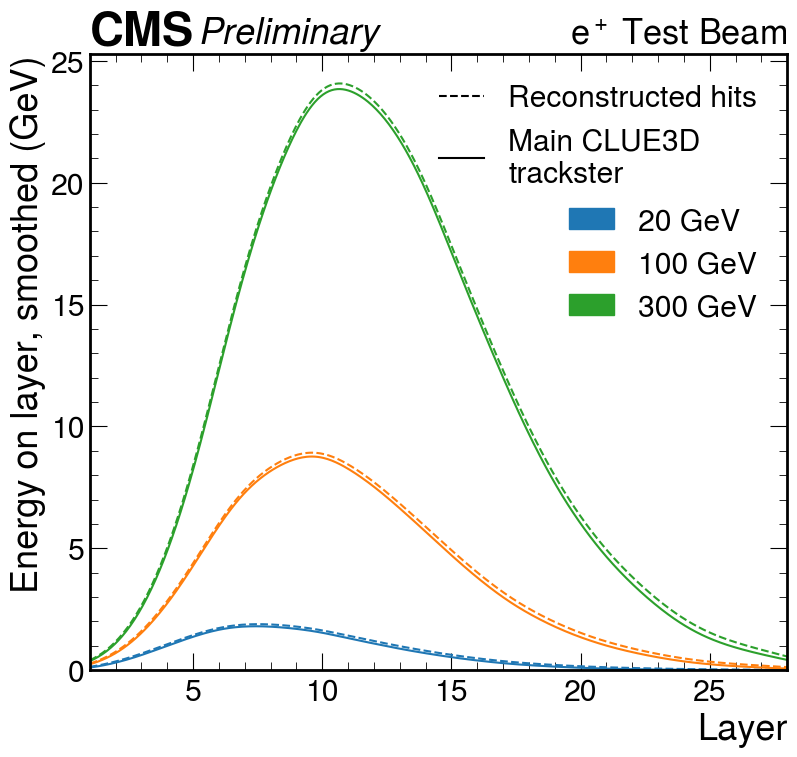

In [18]:
beamEnergiesToPlot_comp = [20., 100., 300.]
colors = ["tab:blue", "tab:orange",# "tab:red", 
          "tab:green"]
datatype = "data"
fig, ax = plt.subplots(figsize=(9, 8))
h_rechits = getHist(datatype, beamEnergiesToPlot_comp, "rechits")
h_clue3d = getHist(datatype, beamEnergiesToPlot_comp, "clue3d")

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
legend_handes = [mlines.Line2D([], [], color='black', linestyle="--", label='Reconstructed hits'),
                 mlines.Line2D([], [], color='black', label='Main CLUE3D\ntrackster')]
for (beamEnergy, h_rec), h_cl, color in zip(h_rechits.items(), h_clue3d.values(), colors):
    plotKDE(h_rec,  ax=ax, linestyle="--", color=color)
    #hep.histplot(h_rec, histtype="errorbar", color=color)
    plotKDE(h_cl, ax=ax, color=color)
    legend_handes.append(mpatches.Patch(color=color, label=f"{int(beamEnergy)} GeV"))


ax.set_xlim(1, 28)
ax.set_xlabel("Layer")
ax.set_ylim(bottom=0)
ax.set_ylabel("Energy on layer, smoothed (GeV)")
legend_1 = ax.legend(handles=legend_handes[:2])
ax.legend(handles=legend_handes[2:], bbox_to_anchor=(1, 0.8))
ax.add_artist(legend_1)
hep.cms.text("Preliminary", ax=ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=ax)
plt.savefig("plots/rechits-clue-comparison.pdf", bbox_inches="tight")

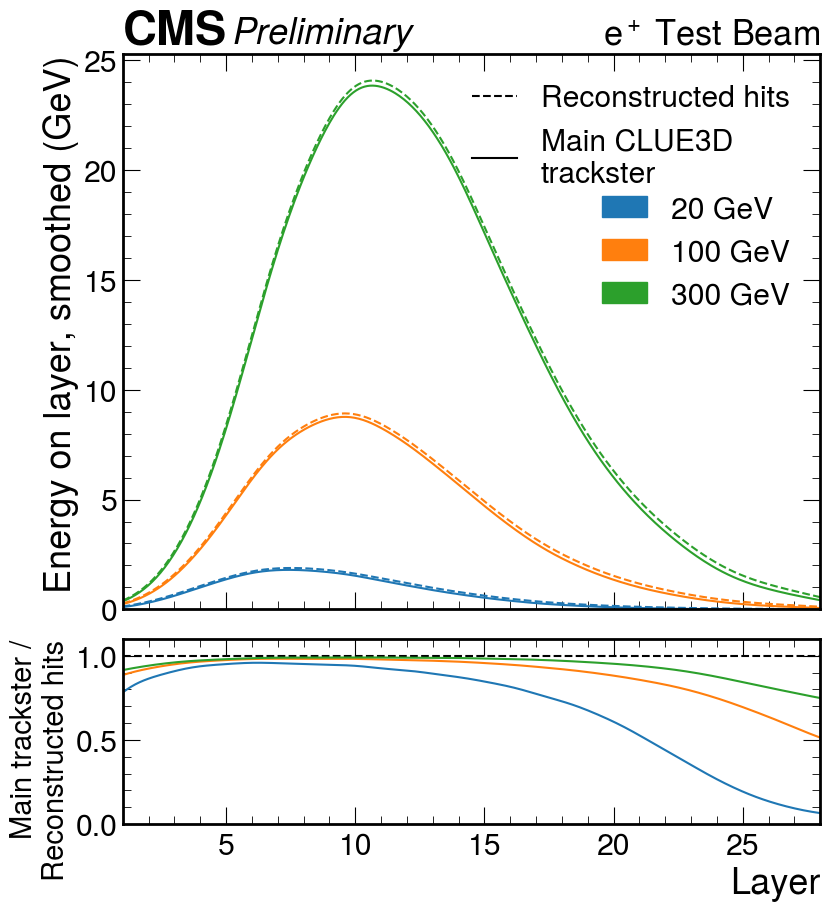

In [19]:
beamEnergiesToPlot_comp = [20., 100., 300.]
colors = ["tab:blue", "tab:orange",# "tab:red", 
          "tab:green"]
datatype = "data"

fig = plt.figure(figsize=(9, 10))
grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
subplot_ax.axhline(1, color="black", linestyle="--")

h_rechits = getHist(datatype, beamEnergiesToPlot_comp, "rechits")
h_clue3d = getHist(datatype, beamEnergiesToPlot_comp, "clue3d")

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
legend_handes = [mlines.Line2D([], [], color='black', linestyle="--", label='Reconstructed hits'),
                 mlines.Line2D([], [], color='black', label='Main CLUE3D\ntrackster')]
for (beamEnergy, h_rec), h_cl, color in zip(h_rechits.items(), h_clue3d.values(), colors):
    xVals, _, kde_rechits = plotKDE(h_rec,  ax=main_ax, linestyle="--", color=color)
    #hep.histplot(h_rec, histtype="errorbar", color=color)
    _, _, kde_clue3d = plotKDE(h_cl, ax=main_ax, color=color)
    legend_handes.append(mpatches.Patch(color=color, label=f"{int(beamEnergy)} GeV"))
    subplot_ax.plot(xVals, kde_clue3d/kde_rechits, color=color)


main_ax.set_xlim(1, 28)
subplot_ax.set_xlabel("Layer")
main_ax.set_ylim(bottom=0)
main_ax.set_ylabel("Energy on layer, smoothed (GeV)")
legend_1 = main_ax.legend(handles=legend_handes[:2])
main_ax.legend(handles=legend_handes[2:], bbox_to_anchor=(1, 0.8))
main_ax.add_artist(legend_1)
hep.cms.text("Preliminary", ax=main_ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=main_ax)

subplot_ax.set_ylabel("Main trackster /\nReconstructed hits", fontsize=21)
subplot_ax.set_ylim(0, 1.1)
plt.savefig("plots/rechits-clue-comparison-ratio.pdf", bbox_inches="tight")